In [1]:
import tensorflow as tf
from datetime import timedelta
import numpy as np
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

## Preparing X, Y

In [2]:
print("Enter timestep : ",end=' ')
timesteps = int(input())
print(timesteps)

Enter timestep :  24


In [3]:
import pandas as pd
from collections import defaultdict

provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla']
path = './data/Train/fire_integrated/'
data = {}

X = defaultdict(lambda: list())
Y = defaultdict(lambda: list())

hour_step = timedelta(hours=timesteps-1)

# Time we have to forecast
predict_at = pd.date_range(start="2016-03-04 00:00:00", end="2019-03-17 23:00:00", freq='6H')

for province in provinces:
    # Read preprocessed data
    df = pd.read_csv(path+f'{province}_fire_integrated.csv', index_col=0, parse_dates=True)
    data[province] = df

    #df = df.fillna(value=0.0)  # Quick fix : frp has some Null

    # Create Input & Output of model
    for base in predict_at:

        if base-hour_step not in df.index : continue
        x = df.loc[base-hour_step: base].drop(['PM2.5'], axis=1)

        till = base+timedelta(hours=72)
        if till not in df.index: break
        y = df.loc[base+timedelta(hours=1): till, ['PM2.5']]

        X[province].append(x)
        Y[province].append(y)


In [4]:
from sklearn.preprocessing import MinMaxScaler

x_scalers, y_scalers = {}, {}

X_scaled = defaultdict(lambda: list())
Y_scaled = defaultdict(lambda: list())

for province in provinces:
    # Standardize x, y
    x = data[province].drop(['PM2.5'], axis=1)
    y = data[province][['PM2.5']]

    x_scaler = MinMaxScaler().fit(x)
    y_scaler = MinMaxScaler().fit(y)

    # Save the scaler for later use
    for e in X[province]:
        X_scaled[province].append(x_scaler.transform(e))
        x_scalers[province] = x_scaler
    for e in Y[province]:
        Y_scaled[province].append(y_scaler.transform(e))
        y_scalers[province] = y_scaler


In [5]:
X.keys()

dict_keys(['Bangkok', 'Chanthaburi', 'Chiang Mai', 'Kanchanaburi', 'Songkhla'])

In [6]:
X['Songkhla'][0].tail()

,Temp(C),WindDir,Wind Speed(km/h),Cambodia_frp,Myanmar_frp,Thailand_frp,Lao_PDR_frp
2016-03-04 08:00:00,25.4,95.0,28.0,0.000000,0.0,0.000000,0.000000
2016-03-04 09:00:00,25.4,95.0,28.0,0.000000,0.0,0.000000,0.000000
2016-03-04 10:00:00,28.8,95.0,28.0,0.000000,0.0,0.000000,0.000000
2016-03-04 11:00:00,28.8,95.0,28.0,0.000000,0.0,0.000000,0.000000
2016-03-04 12:00:00,28.8,95.0,28.0,9.129683,0.0,8.493367,8.115749


In [7]:
Y['Songkhla'][0]

,PM2.5
2016-03-04 13:00:00,22.5
2016-03-04 14:00:00,21.3
2016-03-04 15:00:00,17.6
2016-03-04 16:00:00,22.1
2016-03-04 17:00:00,20.6
...,...
2016-03-07 08:00:00,22.4
2016-03-07 09:00:00,22.3
2016-03-07 10:00:00,19.7
2016-03-07 11:00:00,21.8


## Reshaping input

In [32]:
x_ = np.array(X_scaled['Chanthaburi'])
y_ = np.array(Y_scaled['Chanthaburi'])
print(f'X : {x_.shape}')
print(f'Y : {y_.shape}')

X : (4422, 24, 7)
Y : (4422, 72, 1)


In [33]:
np.isnan(bkk_x).any()

False

In [34]:
n_features = len(data[province].columns)-1
x_train = x_.reshape((x_.shape[0], timesteps, n_features))
y_train = y_.reshape((y_.shape[0], 72))

In [35]:
print(f'x : {x_train.shape}')
print(f'y : {y_train.shape}')

x : (4422, 24, 7)
y : (4422, 72)


## Building Model

In [36]:
print(f"timesteps : {timesteps}")

timesteps : 24


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

# define model
model = Sequential([
    LSTM(200, activation='relu', input_shape=(timesteps, n_features)),
    Dense(144, activation='relu'),
    Dense(72)
])
model.compile(optimizer='adam', loss='mse')

In [38]:
history = model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
139/139 [==============================] - 7s 34ms/step - loss: 0.0255
Epoch 2/5
139/139 [==============================] - 4s 29ms/step - loss: 0.0118
Epoch 3/5
139/139 [==============================] - 4s 30ms/step - loss: 0.0105
Epoch 4/5
139/139 [==============================] - 4s 30ms/step - loss: 0.0102
Epoch 5/5
139/139 [==============================] - 4s 29ms/step - loss: 0.0094


### Evaluate on train

In [19]:
model.evaluate(x_train, y_train)

139/139 [==============================] - 1s 10ms/step - loss: 0.0075


0.0075295367278158665

### Evaluate on test

In [ ]:
model.evaluate(x_test, y_test)

In [29]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_train)
rmse = []
for i in range(len(pred)):
    p = y_scalers['Bangkok'].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = y_scalers['Bangkok'].inverse_transform(y_train[i].reshape((-1,1)))
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

8.626507344193733

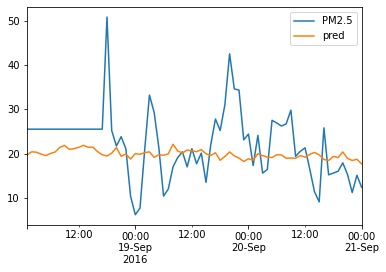

In [31]:
i = 790
h = y_scalers['Bangkok'].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y['Bangkok'][i]
k['pred'] = h
k.plot();